In [1]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
from dask.distributed import Client
from tqdm import tqdm
import json
import fsspec
import fsspec_reference_maker.hdf as fshdf
from glob import glob
import numpy as np

In [6]:
import dask
from dask.distributed import Client

client = Client(n_workers=6)
client

_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:34895 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 6 Memory: 7.52 GB


In [7]:
fs = s3fs.S3FileSystem(anon=True)

In [44]:
days = range(214,280)

In [45]:
files = []
for d in tqdm(days):
    flist = fs.glob("s3://noaa-goes17/ABI-L2-FDCC/2020/"+str(d)+"/*/*.nc")
    [files.append(f) for f in flist]

100%|██████████| 66/66 [01:10<00:00,  1.07s/it]


In [46]:
flist[0]

'noaa-goes17/ABI-L2-FDCC/2020/279/00/OR_ABI-L2-FDCC-M6_G17_s20202790001176_e20202790003549_c20202790004097.nc'

In [47]:
files_small = ["s3://" + f for f in files[::12]]

In [48]:
def gen_json(u):
    import os.path
    so = dict(
        mode="rb", anon=True, default_fill_cache=False, default_cache_type="none"
    )

    with fsspec.open(u, **so) as f:
        fname = u.split("/")[7]
        if os.path.isfile(f"./jsons/{fname}.json"): 
            return
        
        h5chunks = fshdf.SingleHdf5ToZarr(f, u, xarray=True)
        j = h5chunks.translate()
        
        with open(f"./jsons/{fname}.json", "w") as fout:
            fout.write(json.dumps(j))

In [49]:
results = []
for f in files_small:
    results.append(dask.delayed(gen_json)(f))

In [51]:
a=dask.compute(*results)

## Read JSONS

In [8]:
json_list = sorted(glob("./jsons/*.json"))

In [9]:
m_list = []
for js in tqdm(json_list):
    with open(js) as f:
        m_list.append(fsspec.get_mapper("reference://", fo=json.load(f), remote_protocol="s3", remote_options={"anon": True}))


100%|██████████| 1447/1447 [02:57<00:00,  8.15it/s]


In [10]:
%%time
ds = xr. open_mfdataset(m_list, combine='nested', concat_dim='t', 
                      engine='zarr', coords='minimal', data_vars='minimal',
                      compat='override', parallel=True)

CPU times: user 7min 2s, sys: 28.4 s, total: 7min 30s
Wall time: 1h 7min 43s


In [11]:
%%time
ds2 = xr. open_mfdataset(m_list, combine='nested', concat_dim='t', 
                      engine='zarr', coords='minimal', data_vars='minimal',
                      compat='override')

CPU times: user 6min 29s, sys: 40.4 s, total: 7min 9s
Wall time: 1h 18min 5s


In [12]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [13]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [14]:
ds = calc_latlon(ds)
ds

,Array,Chunk
Bytes,21.70 GB,250.00 kB
Shape,"(1447, 1500, 2500)","(1, 250, 250)"
Count,261907 Tasks,86820 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,21.70 GB,250.00 kB
Shape,"(1447, 1500, 2500)","(1, 250, 250)"
Count,261907 Tasks,86820 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [15]:
lons = -124.409591, -114.131211
lats = 32.534156, 42.009518
((x1,x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

In [16]:
subset = ds.sel(x=slice(x1,x2), y=slice(y2,y1))
subset

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, t: 1447, x: 510, y: 380)
Coordinates:
    local_zenith_angle                                float32 ...
    solar_zenith_angle                                float32 ...
    sunglint_angle                                    float32 ...
  * t                                                 (t) datetime64[ns] 2020...
  * x                                                 (x) float32 0.02741 ......
    x_image                                           float32 ...
  * y                                                 (y) float32 0.1126 ... ...
    y_image                                           float32 ...
    lat                                               (y, x) float32 42.0 ......
    lon                                               (y, x) float32 -124.4 ....
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds
Data variables:
    Area                                              (t, y, x) float32 dask.array<chunksize=(1, 222, 11), meta=np.ndarray>
    DQF                                               (t, y, x) float32 dask.array<chunksize=(1, 222, 11), meta=np.ndarray>
    Mask                                              (t, y, x) float32 dask.array<chunksize=(1, 222, 11), meta=np.ndarray>
    Power                                             (t, y, x) float32 dask.array<chunksize=(1, 222, 11), meta=np.ndarray>
    Temp                                              (t, y, x) float32 dask.array<chunksize=(1, 222, 11), meta=np.ndarray>
    algorithm_dynamic_input_data_container            (t) float64 nan ... nan
    algorithm_product_version_container               (t) float64 nan ... nan
    fire_area_outlier_pixel_count                     (t) float64 18.0 ... 35.0
    fire_radiative_power_outlier_pixel_count          (t) float64 0.0 ... 0.0
    fire_temperature_outlier_pixel_count              (t) float64 0.0 ... 0.0
    geospatial_lat_lon_extent                         (t) float64 nan ... nan
    goes_imager_projection                            (t) float64 nan ... nan
    local_zenith_angle_bounds                         (t, number_of_LZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    maximum_fire_area                                 (t) float64 2.534e+05 ....
    maximum_fire_radiative_power                      (t) float64 681.4 ... 1...
    maximum_fire_temperature                          (t) float64 1.114e+03 ....
    mean_fire_area                                    (t) float64 7.249e+04 ....
    mean_fire_radiative_power                         (t) float64 186.2 ... 4...
    mean_fire_temperature                             (t) float64 593.3 ... 6...
    minimum_fire_area                                 (t) float64 2.745e+03 ....
    minimum_fire_radiative_power                      (t) float64 21.83 ... 7...
    minimum_fire_temperature                          (t) float64 416.3 ... 4...
    nominal_satellite_height                          (t) float64 3.579e+04 ....
    nominal_satellite_subpoint_lat                    (t) float64 0.0 ... 0.0
    nominal_satellite_subpoint_lon                    (t) float64 -137.2 ... ...
    percent_uncorrectable_GRB_errors                  (t) float64 0.0 ... 0.0
    percent_uncorrectable_L0_errors                   (t) float64 0.0 ... 0.0
    processing_parm_version_container                 (t) float64 nan ... nan
    solar_zenith_angle_bounds                         (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    standard_deviation_fire_area                      (t) float64 8.102e+04 ....
    standard_deviation_fire_radiative_power           (t) float64 168.1 ... 3...
    standard_deviation_fire_temperature     

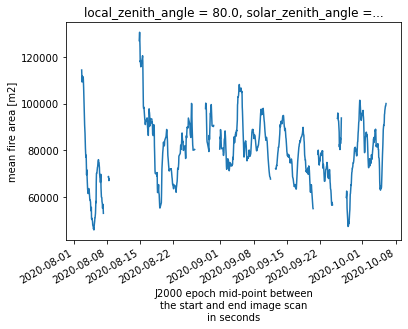

In [29]:
subset.sel(t="2020").mean_fire_area.rolling(t=24).mean(skipna=True).plot()